In [24]:
import JSON
using Plots
using HDF5
using Trapz
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")

get_params (generic function with 3 methods)

In [26]:
border = import_border("../data/border.json")
dx = 20
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

x = repeat(reshape(xrange,1,Nx),Ny,1)
y = repeat(reshape(yrange,Ny,1),1,Nx)
x_for_bx = repeat(reshape(xrange,1,Nx),Ny,1) .- dx/2
y_for_bx = repeat(reshape(yrange,Ny,1),1,Nx)
x_for_by = repeat(reshape(xrange,1,Nx),Ny,1)
y_for_by = repeat(reshape(yrange,Ny,1),1,Nx) .+ dx/2;


7522-element Vector{CartesianIndex{2}}:
 CartesianIndex(14, 4)
 CartesianIndex(15, 4)
 CartesianIndex(16, 4)
 CartesianIndex(19, 4)
 CartesianIndex(20, 4)
 CartesianIndex(21, 4)
 CartesianIndex(22, 4)
 CartesianIndex(23, 4)
 CartesianIndex(24, 4)
 CartesianIndex(14, 5)
 CartesianIndex(15, 5)
 CartesianIndex(16, 5)
 CartesianIndex(17, 5)
 ⋮
 CartesianIndex(48, 152)
 CartesianIndex(49, 152)
 CartesianIndex(50, 152)
 CartesianIndex(51, 152)
 CartesianIndex(52, 152)
 CartesianIndex(53, 152)
 CartesianIndex(54, 152)
 CartesianIndex(51, 153)
 CartesianIndex(52, 153)
 CartesianIndex(53, 153)
 CartesianIndex(54, 153)
 CartesianIndex(54, 154)

In [15]:
recompute_param = true
sigma = 100.
if(recompute_param)
    bx, by, p, m, d = get_params(isinside, sigma, "../data/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5")
else
    bx, by, p, m, d = get_params("../numerics/grid_params_" * string(dx) * ".h5")
end

Computing grid parameters, it might take a while...
Computing grid parameters, it might take a while...


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [16]:
interval = 1000
Niter = 10000
th = zeros(Ny, Nx)

@time begin
    for k in 1:Niter
        if(mod(k,interval) == 0)
            temp = copy(th)
        end
        Threads.@threads for i in 2:Ny-1
            Threads.@threads for j in 2:Nx-1
                if(isinside[i,j])
                    bij = (by[i-1,j] + by[i,j] + bx[i,j] + bx[i,j+1])
                    th[i,j] = (by[i,j] * th[i+1,j] + by[i-1,j] * th[i-1,j] + 
                        bx[i,j+1] * th[i,j+1] + bx[i,j] * th[i,j-1] + dx^2*p[i,j]) / bij

                    if(isnan(th[i,j]))
                        th[i,j] = 0
                    end                   
                        
                end
            end
        end   
        if(mod(k,interval) == 0)
            println([k maximum(abs.(th-temp))])
        end

    end
end


[1000.0 4.736943233107915e-5]
[2000.0 7.853755844888788e-6]
[3000.0 1.3171357018115781e-6]
[4000.0 2.2098512167390005e-7]
[5000.0 3.7079078946122834e-8]
[6000.0 6.221395176808642e-9]
[7000.0 1.0438991338013182e-9]
[8000.0 1.7515758288233485e-10]
[9000.0 2.938929655194045e-11]
[10000.0 4.931333119628789e-12]
 19.266414 seconds (1.66 G allocations: 24.776 GiB, 24.66% gc time, 0.19% compilation time)


NaN
NaN


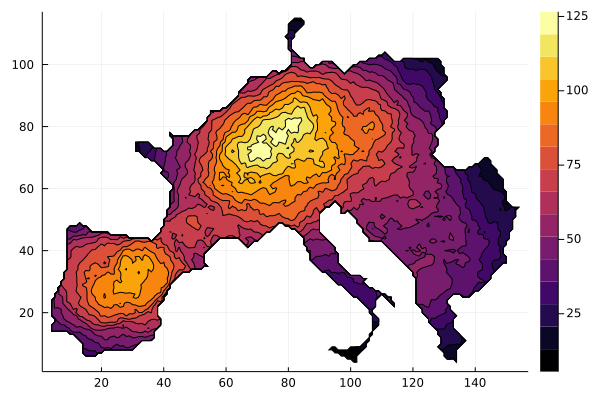

In [22]:
println(maximum(th))
println(minimum(th))
do_plot(isinside, by)
#do_plot(isgrid, p)


In [10]:
fid = h5open("../numerics/stable_" * string(dx) * ".h5", "w")
write(fid, "th", th)
close(fid)